# Unsupervised learning 
### The purpose of this notebook is to show how kmeans clustering works using an example dataset from Donors Choose

In [1]:
# Import libraries we'll need
import os
import glob2
from IPython.display import Image, display
import pandas as pd
import pipeline as pl  # import the functions from our pipeline
import unsupervised_learning_functions as ulf  # import unsupervised learning functions
import sklearn.preprocessing
from sklearn import metrics
import numpy as np
%matplotlib inline

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## Required functionality according to the homework write up
The functionality should include:
1. load data from a csv ----- ✓
2. process the data so it’s ready for clustering ----- ✓
3. Given a k, generate k clusters using one of the clustering methods (k-means is fine for this) ----- ✓
4. For each cluster:
    * Provide summary stats for the cluster ----- ✓
    * Describe (using statistics, graphs, or any other visualizations) what types of data points are in this cluster ----- ✓
    * What are the distinctive features of data points in this cluster (you might want to use decision trees here) ----- ✓
5. Allow the user to
    * merge several clusters into one ----- ✓
    * recluster with a new k ----- ✓
    * Split a specific cluster into many (with a specific number of new clusters) ----- ✓

# Working with the project grant database

# Part 1: kmeans clusters on all of the data

In [2]:
# load the data
projects = pl.load_and_peek_at_data('raw data/projects_2012_2013.csv',
                                 date_vars=['date_posted', 'datefullyfunded'],
                                 summary=False)

************************
************************


Head of data:
                          projectid                    teacher_acctid  \
0  00001ccc0e81598c4bd86bacb94d7acb  96963218e74e10c3764a5cfb153e6fea   
1  0000fa3aa8f6649abab23615b546016d  2a578595fe351e7fce057e048c409b18   
2  000134f07d4b30140d63262c871748ff  26bd60377bdbffb53a644a16c5308e82   
3  0001f2d0b3827bba67cdbeaa248b832d  15d900805d9d716c051c671827109f45   
4  0004536db996ba697ca72c9e058bfe69  400f8b82bb0143f6a40b217a517fe311   

                           schoolid  school_ncesid  school_latitude  \
0  9f3f9f2c2da7edda5648ccd10554ed8c   1.709930e+11        41.807654   
1  3432ed3d4466fac2f2ead83ab354e333   6.409801e+10        34.296596   
2  dc8dcb501c3b2bb0b10e9c6ee2cd8afd   6.227100e+10        34.078625   
3  8bea7e8c6e4279fca6276128db89292e   3.600090e+11        40.687286   
4  fbdefab6fe41e12c55886c610c110753   3.606870e+11        40.793018   

   school_longitude    school_city school_state school_metro  \
0   

In [3]:
# make dummy vars
cat_vars = ['primary_focus_subject', 'secondary_focus_area', 'secondary_focus_subject',
            'school_metro', 'school_charter', 'school_magnet',
           'primary_focus_area', 'resource_type', 'poverty_level', 'grade_level',
           'eligible_double_your_impact_match']
# make dummy outcome var
projects['60_day_outcome'] = (projects['datefullyfunded'] -
                              projects['date_posted']) > pd.Timedelta('60 days')
non_dummy_vars = ['date_posted', 'students_reached',
                'total_price_including_optional_support']
# make our dummy variables
projects = pl.make_dummies_subset_df(projects, cat_vars, non_dummy_vars)
# fill missing values
pl.fill_missing(projects, imputation_method='median')
# standardize vars
projects = pl.standardize_vars(projects, ['students_reached', 'total_price_including_optional_support'])
# drop the "false" variables since we have separate "true" variables for some of the dummies
cols_to_keep = [c for c in projects.columns if c.lower()[-2:] != '_f']
projects = projects[cols_to_keep]
# drop the date posted variable since we don't need it for kmeans clustering
# we could've used it if we think there's a time component but I chose to drop it.
projects = projects.drop('date_posted', axis=1)

### We can calculate kmeans models with different values of k:

In [4]:
kmeans6 = ulf.calculate_kmeans_clusters(data=projects, number_of_clusters=6)

number of clusters is 6


In [5]:
kmeans10 = ulf.calculate_kmeans_clusters(data=projects, number_of_clusters=10)

number of clusters is 10


### We can see which variables have a 75th percentile >= 1 for each cluster:

In [6]:
ulf.output_dummy_vars_by_cluster_with_lots_of_1s(projects, kmeans6.labels_)

This output will tell you which dummy variables in each cluster had a lot of 1s.
The idea is that this will help give a sense of which traits differentiate the clusters.




********************Cluster:  0
variables with 75th percentile >=1:

D_primary_focus_subject_Mathematics
D_secondary_focus_area_Music & The Arts
D_secondary_focus_subject_Visual Arts
D_school_metro_urban
D_primary_focus_area_Math & Science
D_resource_type_Supplies
D_poverty_level_highest poverty
D_grade_level_Grades PreK-2




********************Cluster:  1
variables with 75th percentile >=1:

D_primary_focus_subject_Civics & Government
D_secondary_focus_area_Literacy & Language
D_secondary_focus_subject_Literature & Writing
D_school_metro_urban
D_primary_focus_area_History & Civics
D_resource_type_Books
D_poverty_level_highest poverty
D_grade_level_Grades 3-5
D_eligible_double_your_impact_match_t




********************Cluster:  2
variables with 75th percentile >=1:

D_primary_focus_subject_Literacy
D_secondary_

### We can make a barplot of the mean values of our varibles within each cluster, for the variables that have a mean > 0:

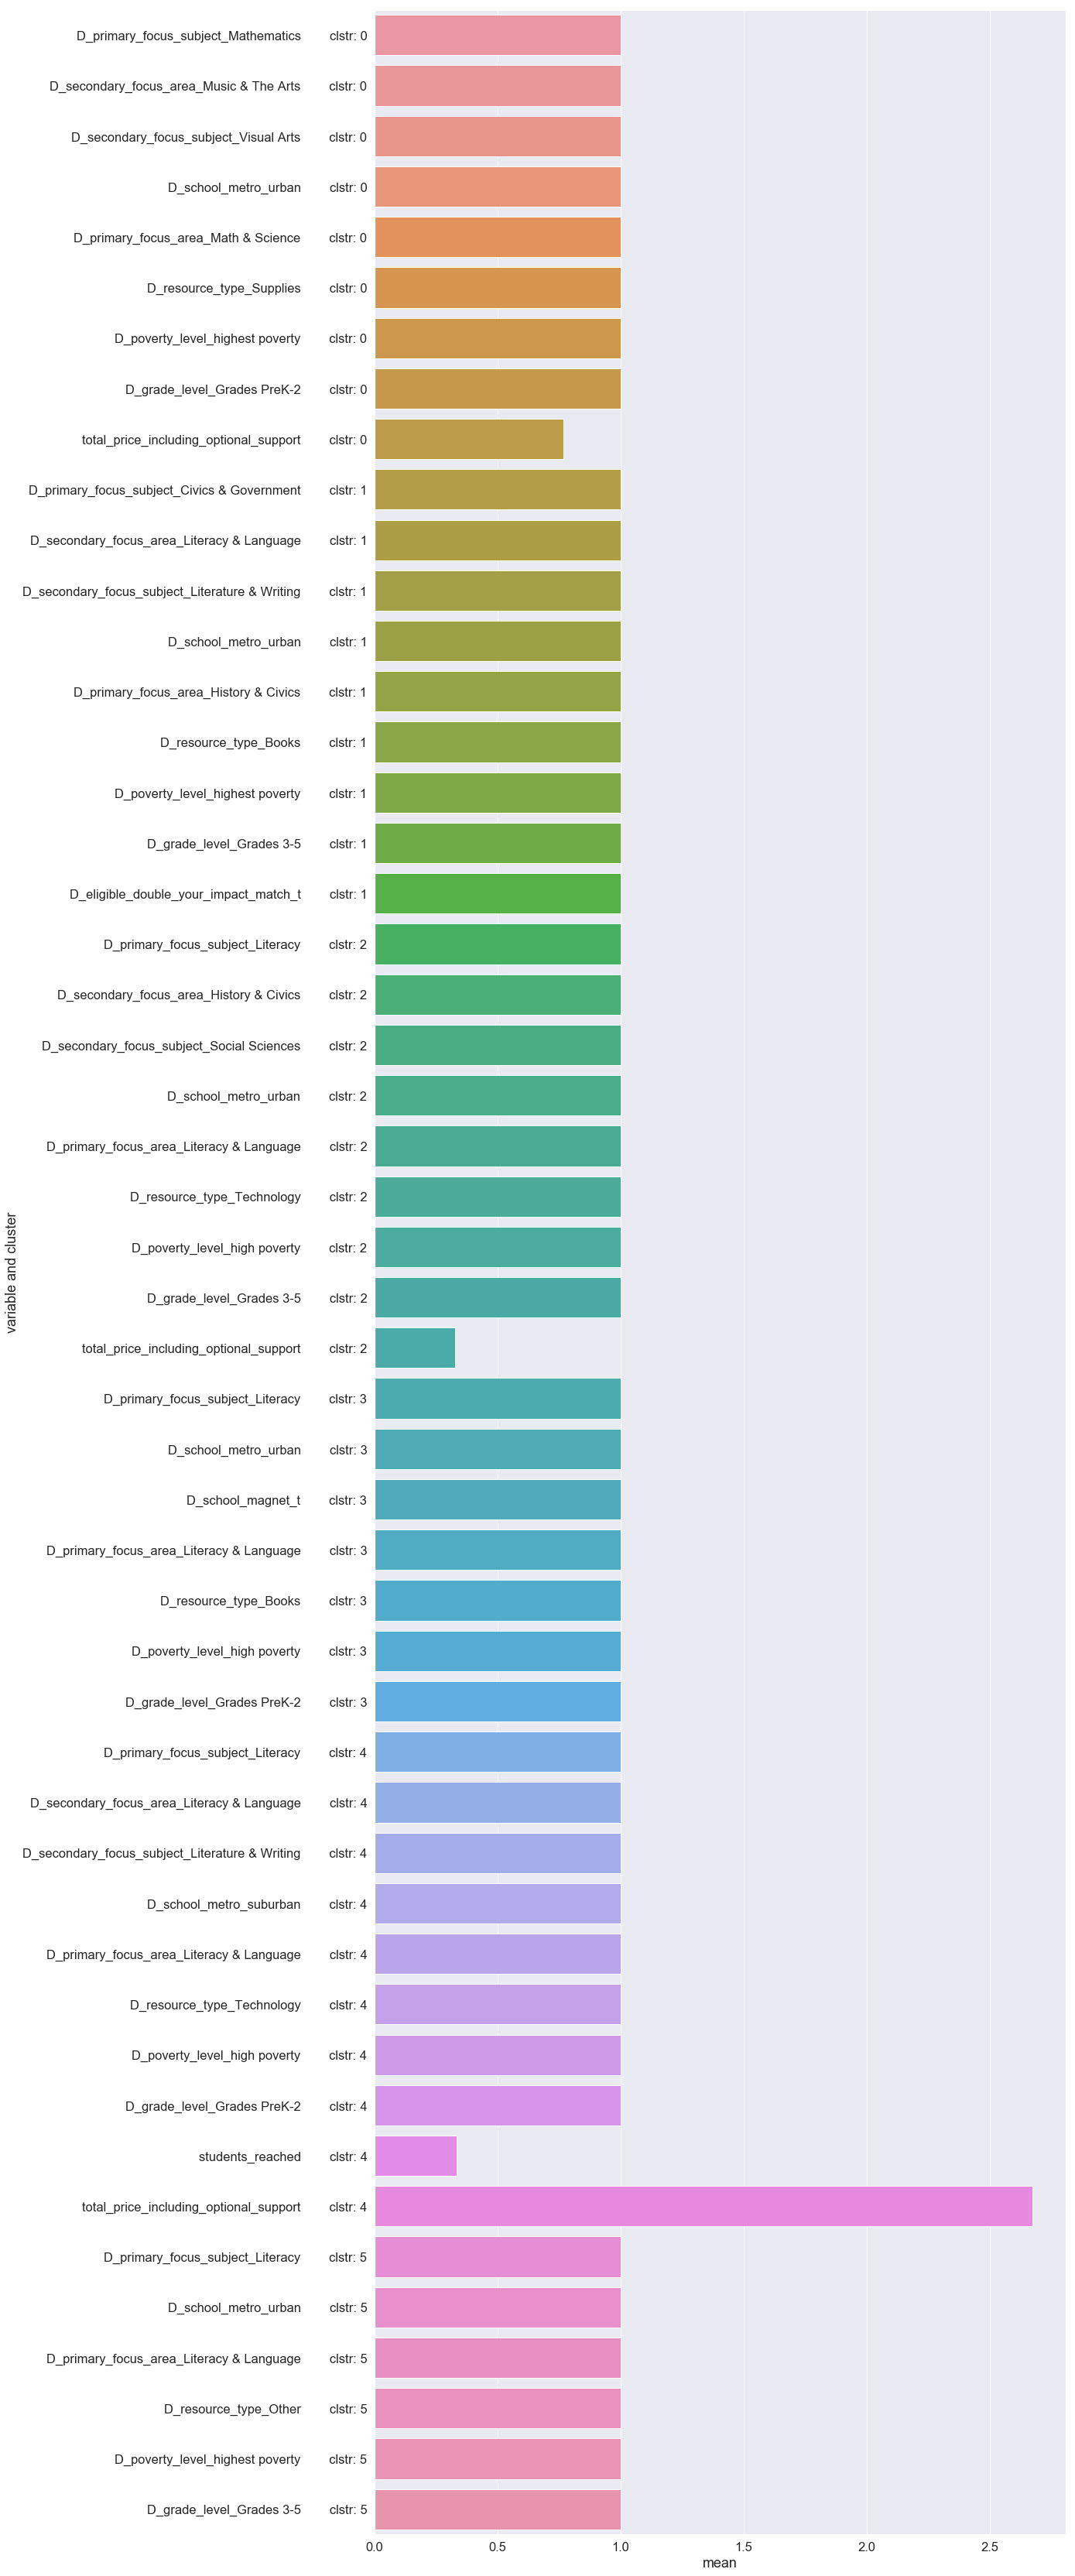

In [7]:
ulf.make_barplot_of_variable_means_by_cluster(data=projects, mymodel_labels=kmeans6.labels_)

### We can make a dot plot (with some added jitter so the points don't overlap) of the mean values of the all the variables by cluster:

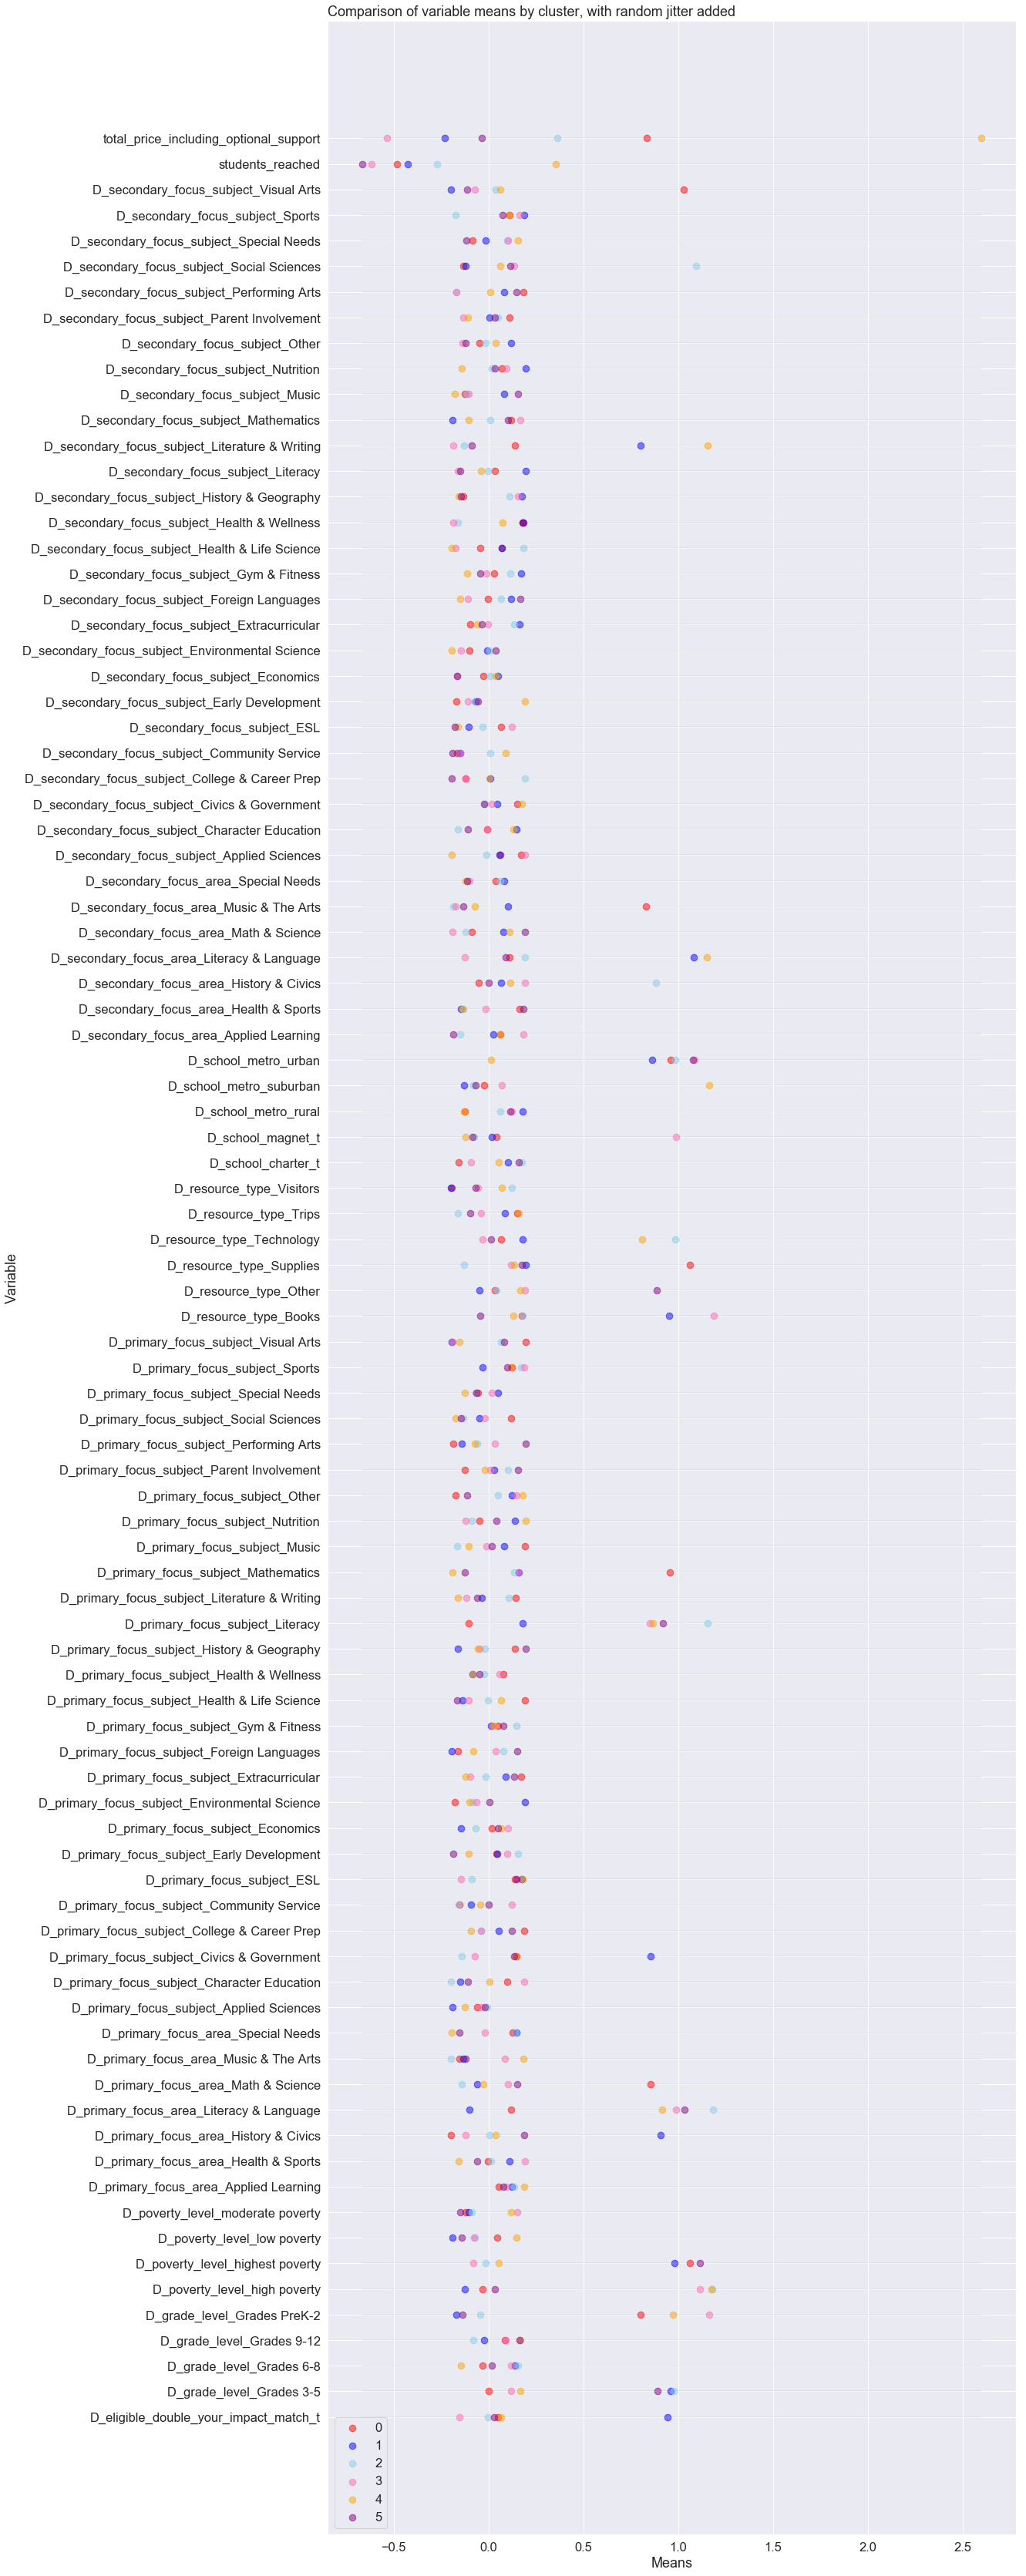

In [8]:
ulf.make_dotplot_of_variable_means_by_cluster(data=projects, mymodel_labels=kmeans6.labels_)

### We can get the feature importances by cluster:

In [9]:
ulf.get_tree_feature_importances_by_cluster(data=projects, mymodel_labels=kmeans6.labels_)

This gives feature importances for our various clusters:

current cluster is  0
                                         var  importance
70       D_primary_focus_area_Math & Science    0.526974
69  D_primary_focus_area_Literacy & Language    0.277065
88                          students_reached    0.190173
89    total_price_including_optional_support    0.003613
71     D_primary_focus_area_Music & The Arts    0.000195




current cluster is  1
                                             var  importance
69      D_primary_focus_area_Literacy & Language    0.557299
86                   D_grade_level_Grades PreK-2    0.427780
88                              students_reached    0.014274
89        total_price_including_optional_support    0.000261
16  D_primary_focus_subject_Literature & Writing    0.000089




current cluster is  2
                                       var  importance
89  total_price_including_optional_support         1.0
67    D_primary_focus_area_Health & Sports        

### We can recluster within an existing cluster and make the same graphs:

In [10]:
new_clusters, subset_data = ulf.create_kmeans_clusters_within_cluster(
    data=projects,
    cluster_we_will_cluster_within=1, 
    number_of_new_clusters=3,
    current_model=kmeans6)

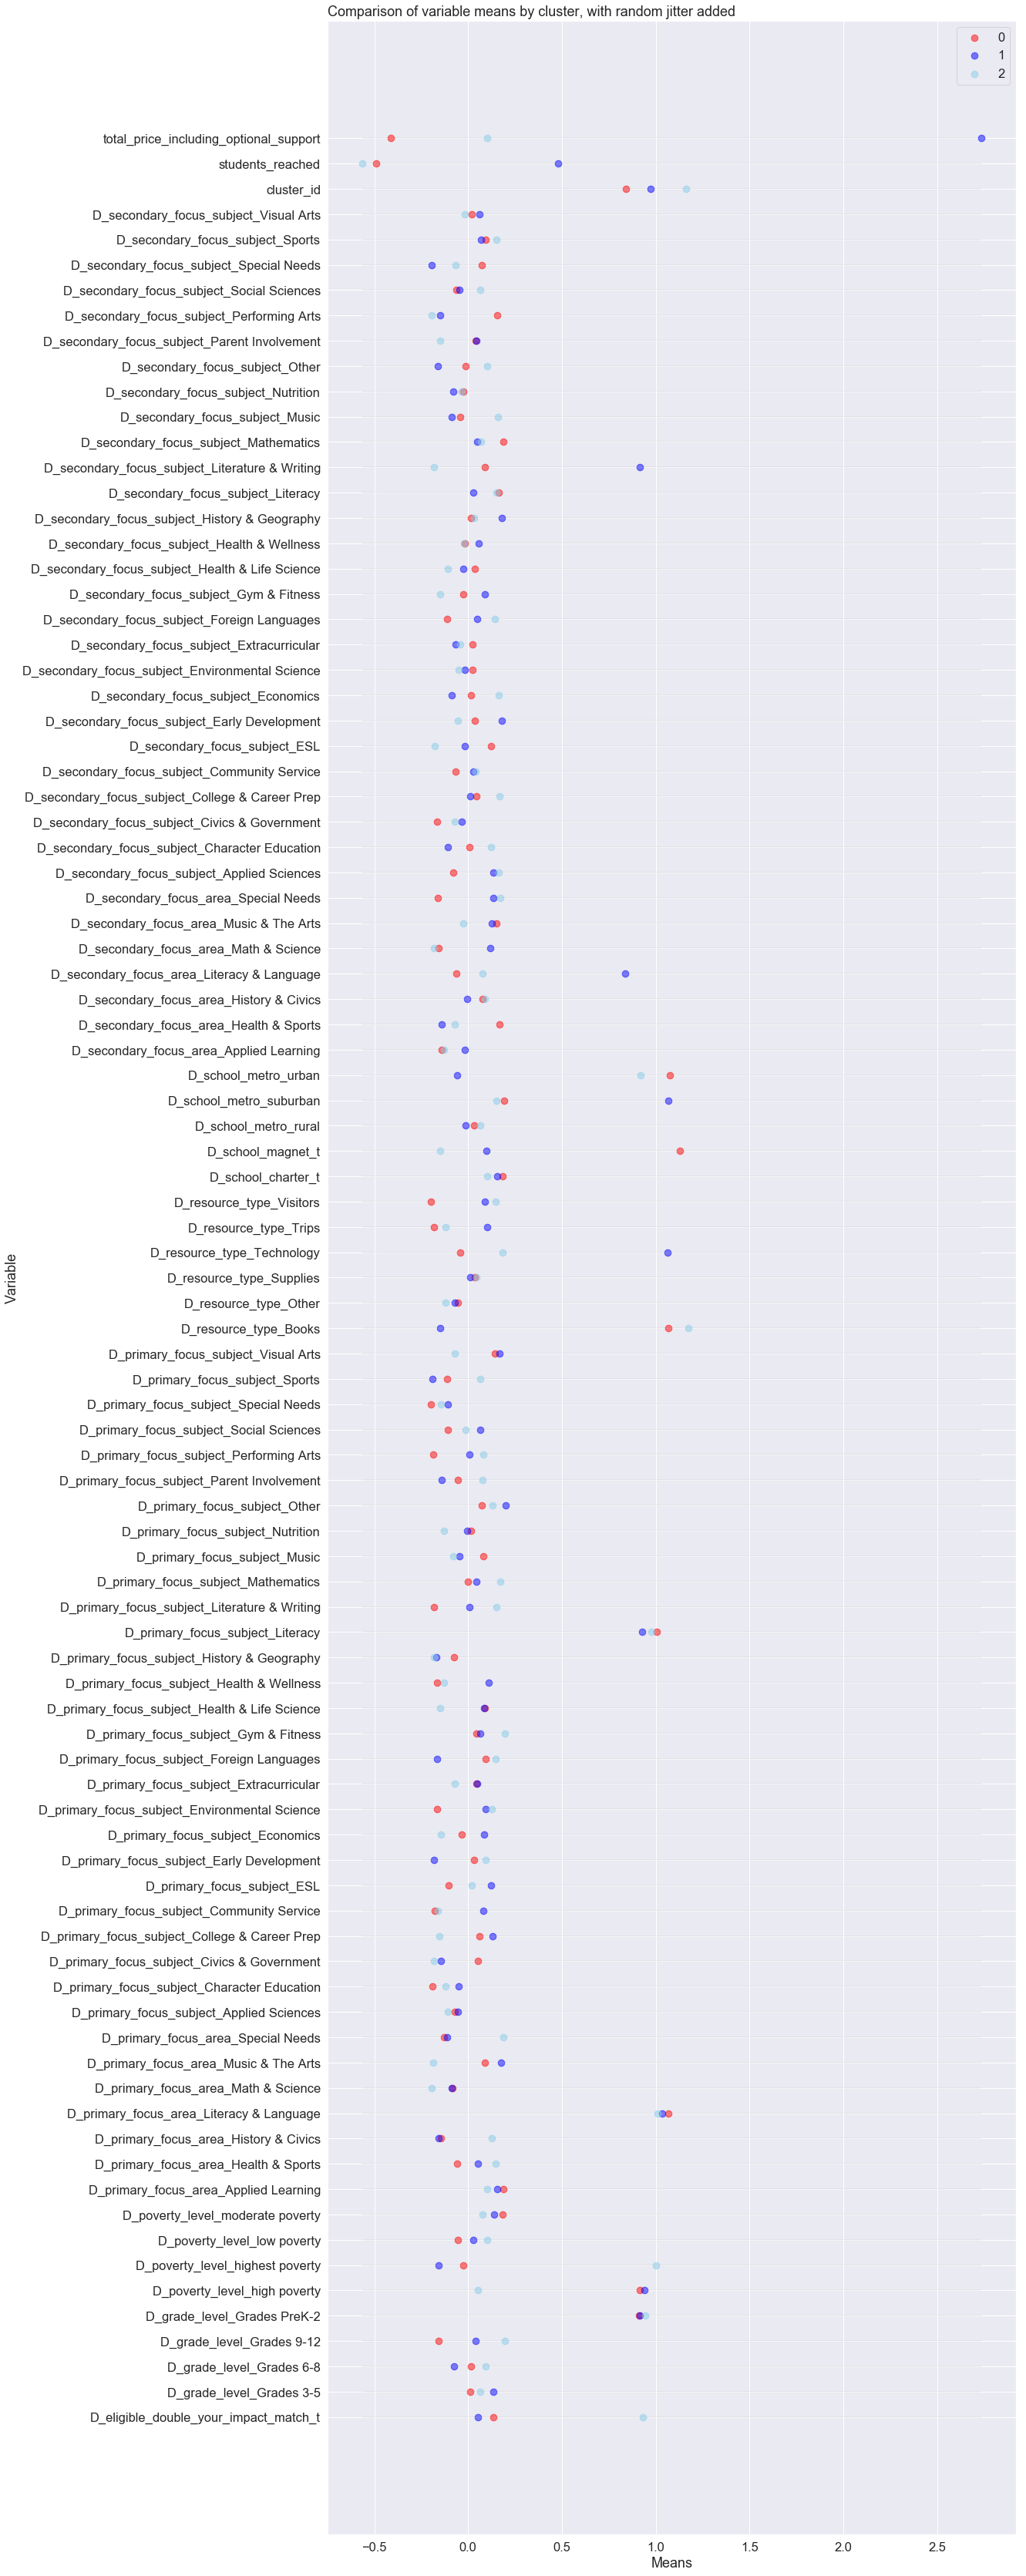

In [11]:
ulf.make_dotplot_of_variable_means_by_cluster(subset_data, new_clusters.labels_)

### We can merge several clusters and redo our analysis:

data copied
labels changed on data_copy
first_cluster id created
other values created
renamed clusters
This output will tell you which dummy variables in each cluster had a lot of 1s.
The idea is that this will help give a sense of which traits differentiate the clusters.




********************Cluster:  0
variables with 75th percentile >=1:

D_primary_focus_subject_Literacy
D_school_metro_urban
D_school_magnet_t
D_primary_focus_area_Literacy & Language
D_resource_type_Books
D_poverty_level_high poverty
D_grade_level_Grades PreK-2
cluster_id




********************Cluster:  2
variables with 75th percentile >=1:

D_primary_focus_subject_Literacy
D_school_metro_urban
D_primary_focus_area_Literacy & Language
D_resource_type_Books
D_poverty_level_highest poverty
D_grade_level_Grades PreK-2
D_eligible_double_your_impact_match_t
cluster_id
This gives feature importances for our various clusters:

current cluster is  0
                                      var  importance
80        D_povert

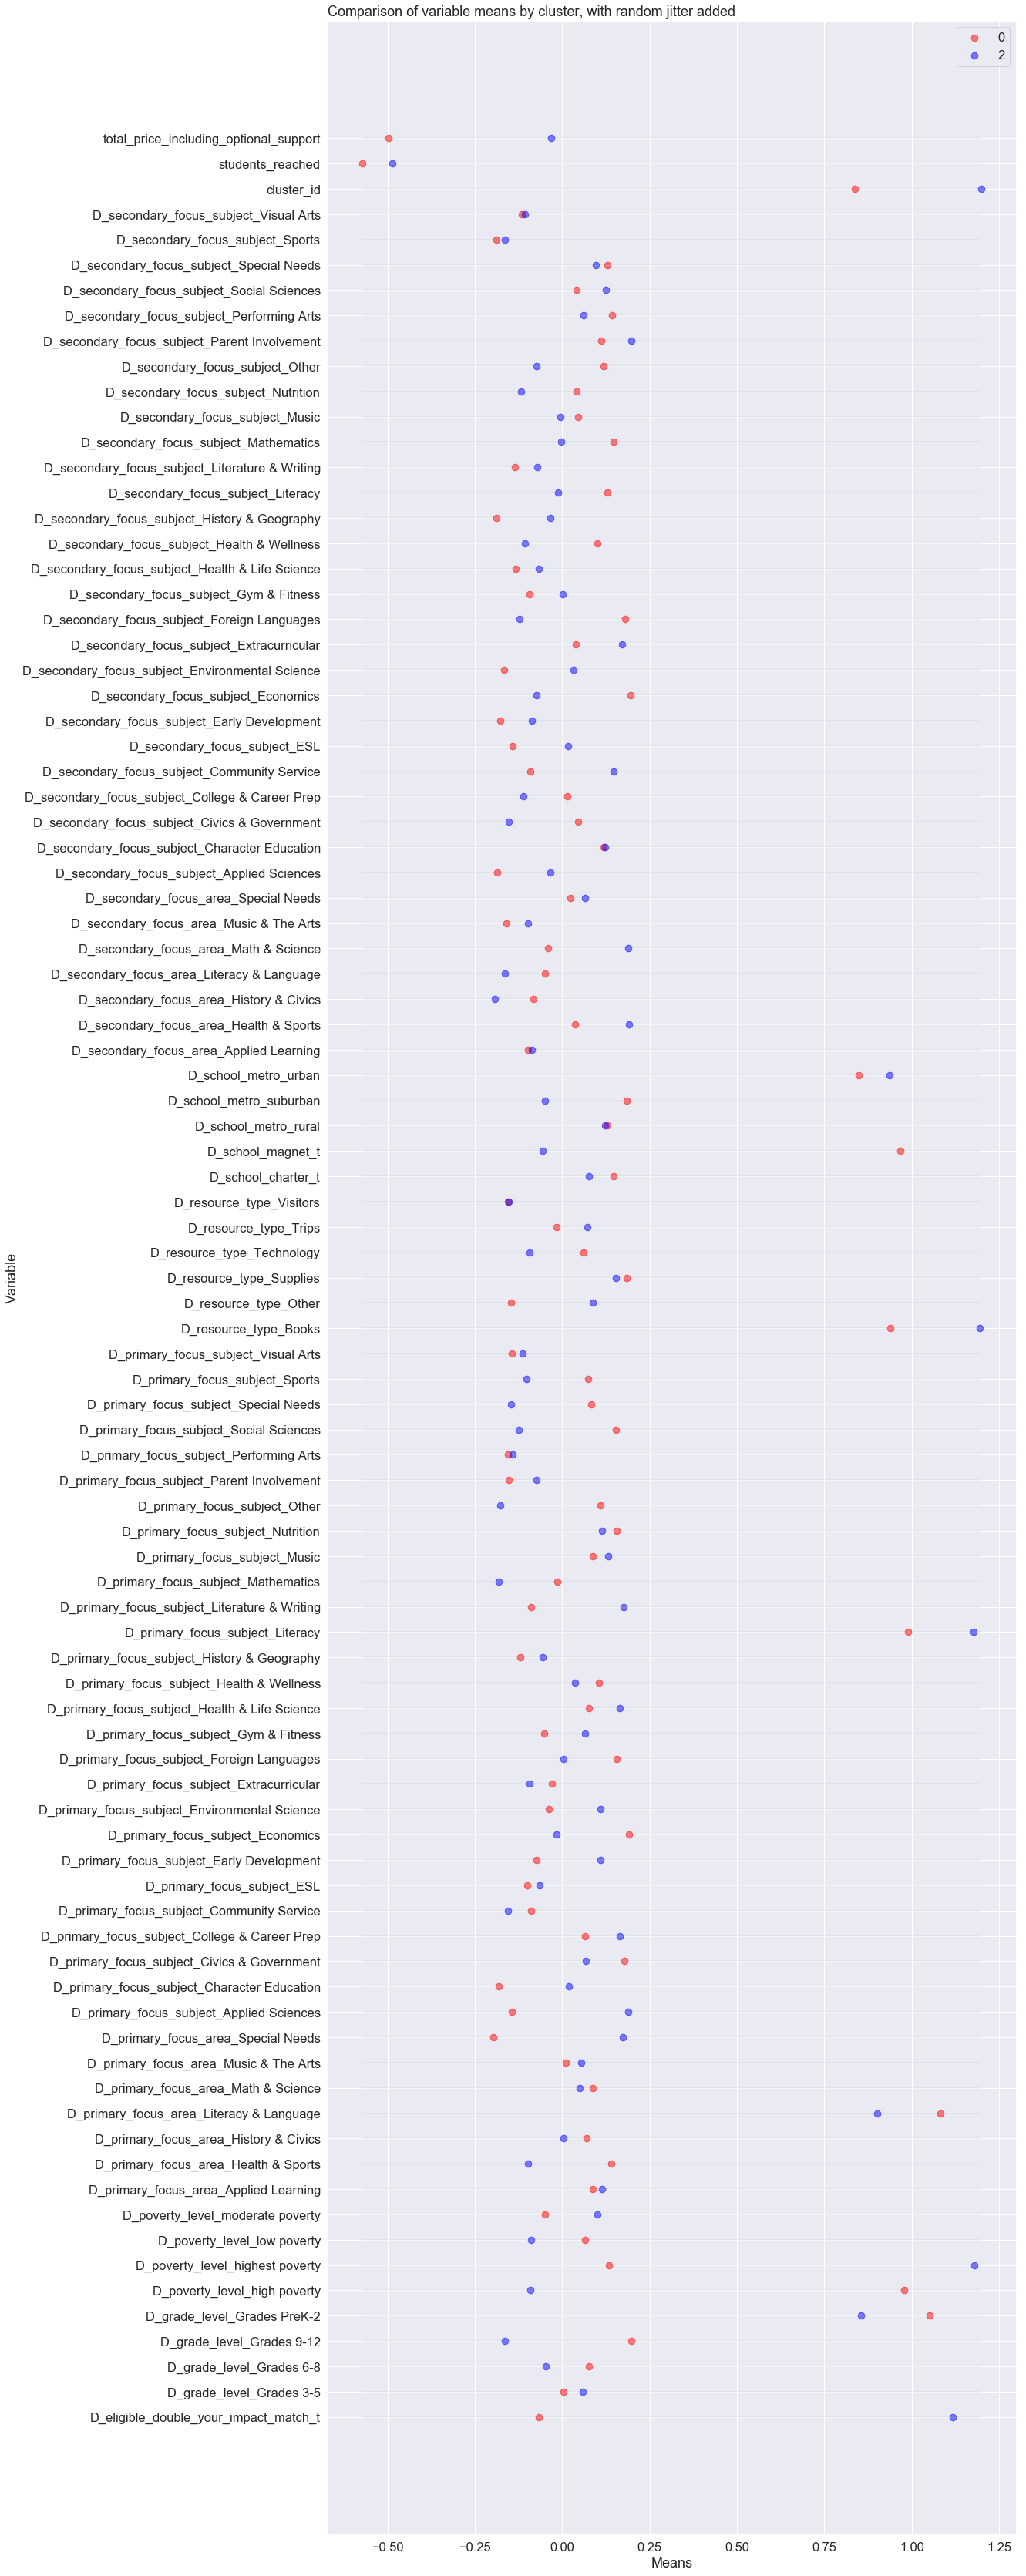

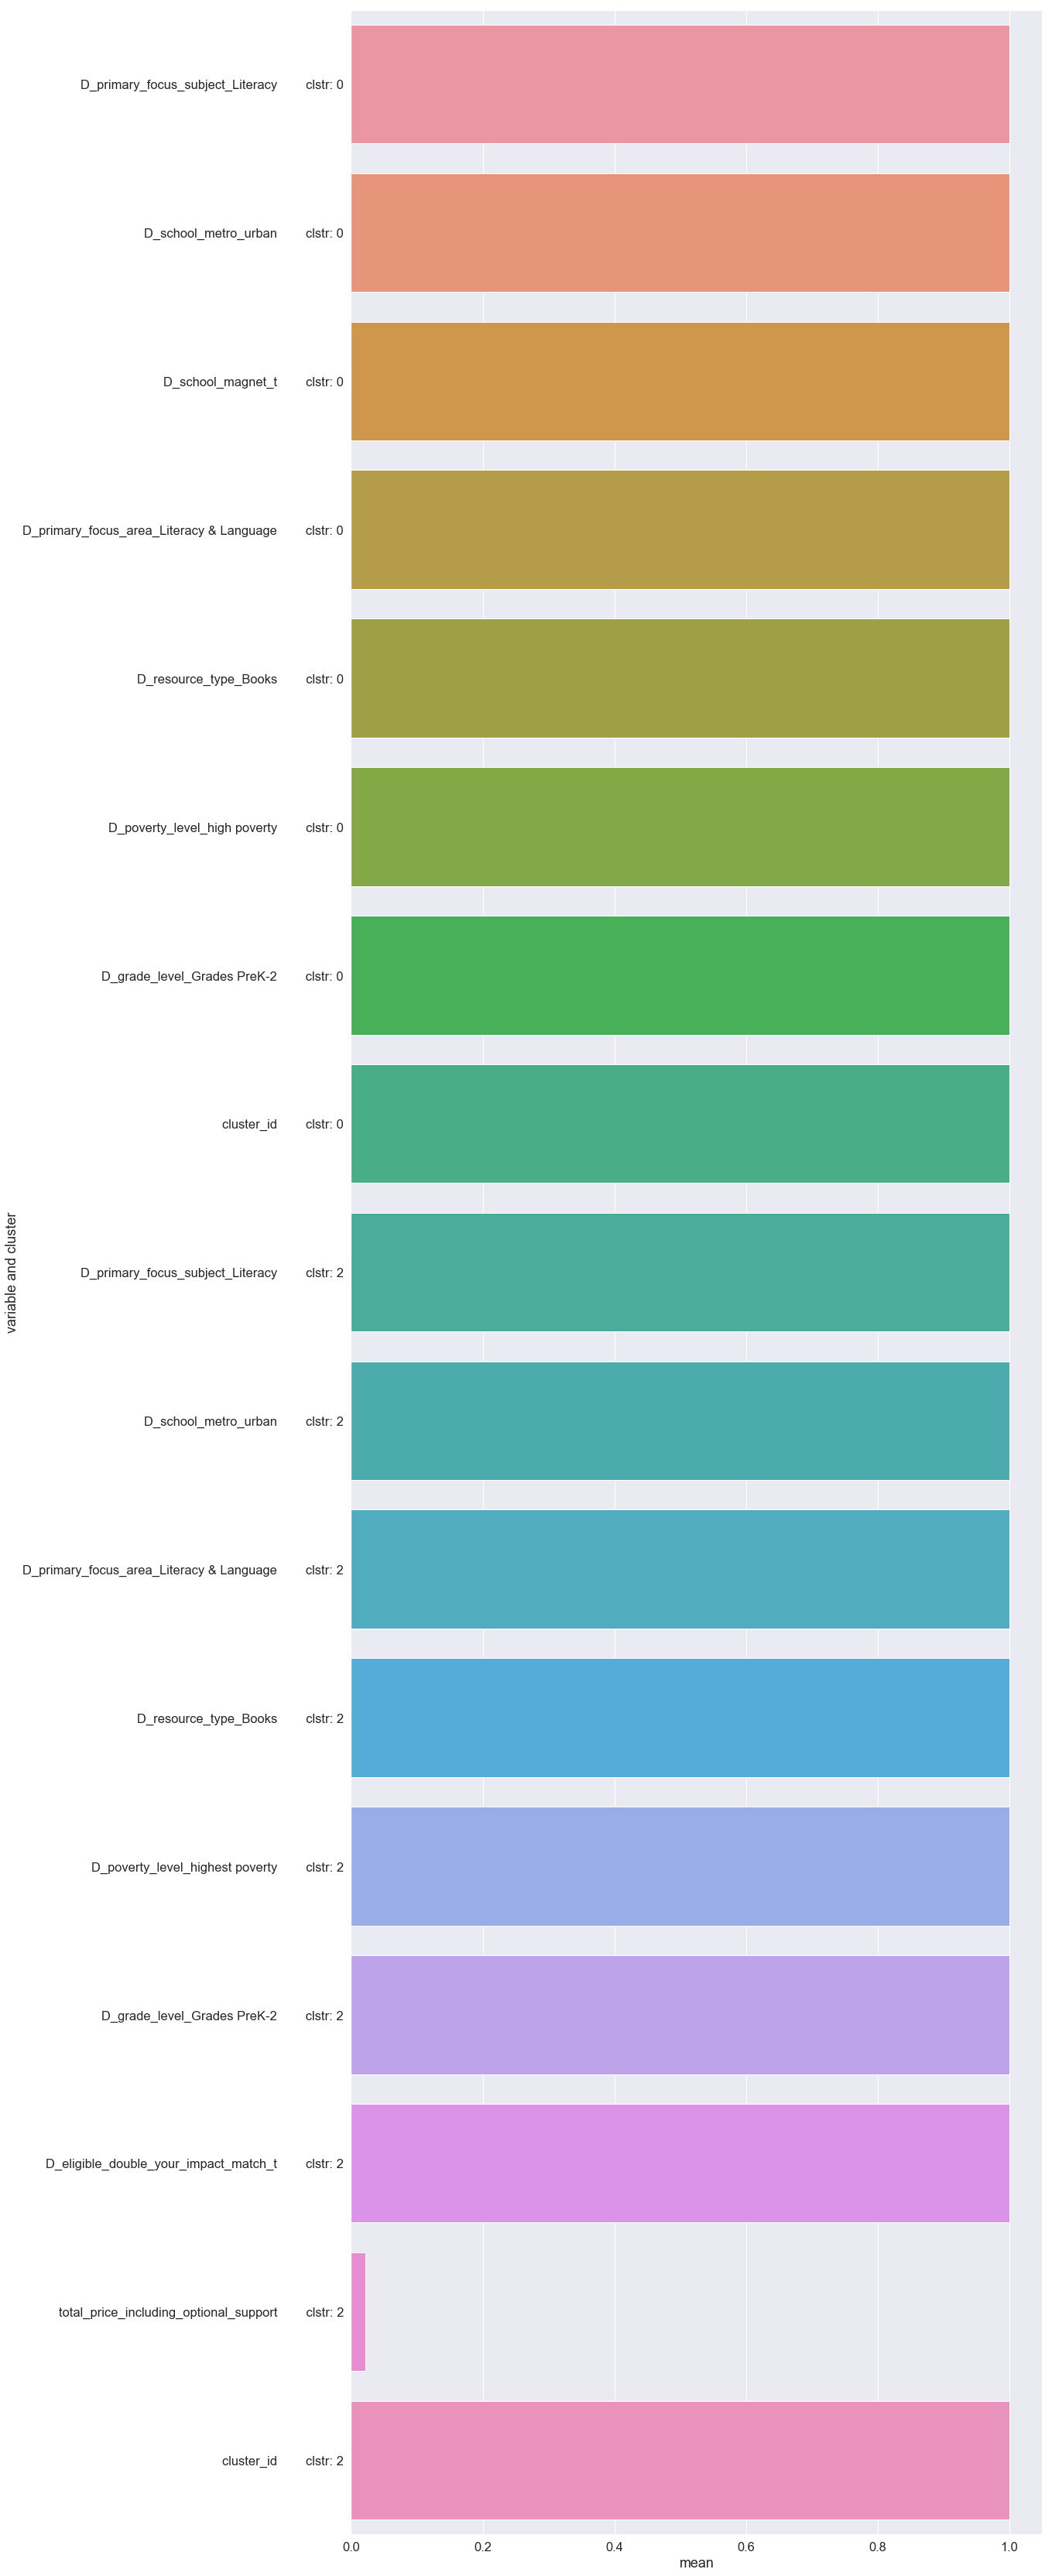

In [12]:
ulf.redo_analysis_with_merged_cluster(data=subset_data,
                                  mymodel_labels=new_clusters.labels_,
                                  list_of_clusters_to_merge=[0,1])

# Part 2: kmeans clustering on the 5% of highest risk projects

In [13]:
projects = pl.load_and_peek_at_data('raw data/projects_2012_2013.csv',
                                 date_vars=['date_posted', 'datefullyfunded'],
                                 summary=True)

************************
************************


Head of data:
                          projectid                    teacher_acctid  \
0  00001ccc0e81598c4bd86bacb94d7acb  96963218e74e10c3764a5cfb153e6fea   
1  0000fa3aa8f6649abab23615b546016d  2a578595fe351e7fce057e048c409b18   
2  000134f07d4b30140d63262c871748ff  26bd60377bdbffb53a644a16c5308e82   
3  0001f2d0b3827bba67cdbeaa248b832d  15d900805d9d716c051c671827109f45   
4  0004536db996ba697ca72c9e058bfe69  400f8b82bb0143f6a40b217a517fe311   

                           schoolid  school_ncesid  school_latitude  \
0  9f3f9f2c2da7edda5648ccd10554ed8c   1.709930e+11        41.807654   
1  3432ed3d4466fac2f2ead83ab354e333   6.409801e+10        34.296596   
2  dc8dcb501c3b2bb0b10e9c6ee2cd8afd   6.227100e+10        34.078625   
3  8bea7e8c6e4279fca6276128db89292e   3.600090e+11        40.687286   
4  fbdefab6fe41e12c55886c610c110753   3.606870e+11        40.793018   

   school_longitude    school_city school_state school_metro  \
0   

In [14]:
# make dummy vars
cat_vars = ['primary_focus_subject', 'secondary_focus_area', 'secondary_focus_subject',
            'school_metro', 'school_charter', 'school_magnet',
           'primary_focus_area', 'resource_type', 'poverty_level', 'grade_level',
           'eligible_double_your_impact_match']

In [15]:
# make dummy outcome var
projects['60_day_outcome'] = (projects['datefullyfunded'] -
                              projects['date_posted']) > pd.Timedelta('60 days')
# training and test sets
test_set_ranges = [('2012-01-01', '2012-04-30', '2012-07-01', '2012-10-31'), 
                   ('2012-01-01', '2012-10-31', '2013-01-01', '2013-04-30'), 
                   ('2012-01-01', '2013-04-30', '2013-07-01', '2013-10-31')]
# continuous vars
non_dummy_vars = ['date_posted', 'students_reached',
                'total_price_including_optional_support', '60_day_outcome']
# drop the "false" variables since we have separate "true" variables for some of the dummies
cols_to_keep = [c for c in projects.columns if c.lower()[-2:] != '_f']
projects = projects[cols_to_keep]

In [16]:
# We're just going to use the first training/test split for this kmeans analysis
date_subset = test_set_ranges[0]
train, test = pl.split_using_date(projects,
                               train_start_date=date_subset[0],
                               train_end_date=date_subset[1],
                               test_start_date=date_subset[2],
                               test_end_date=date_subset[3])
print('training start and end dates are ', date_subset[:2], '\ntraining data dimensions:', train.shape)

train = pl.make_dummies_subset_df(train, cat_vars, non_dummy_vars)
test = pl.make_dummies_subset_df(test, cat_vars, non_dummy_vars)

# Fill missing values
pl.fill_missing(train, imputation_method='median')
pl.fill_missing(test, imputation_method='median')
# standardize vars
train = pl.standardize_vars(train, ['students_reached', 'total_price_including_optional_support'])
test = pl.standardize_vars(test, ['students_reached', 'total_price_including_optional_support'])

# Split our training and test sets into x and y variables:
x, x_t = (train.drop(['60_day_outcome', 'date_posted'], axis=1),
    test.drop(['60_day_outcome', 'date_posted'], axis=1))
scaling = sklearn.preprocessing.MinMaxScaler(feature_range=(-1,1)).fit(x)
x_scaled = scaling.transform(x)
scaling = sklearn.preprocessing.MinMaxScaler(feature_range=(-1,1)).fit(x_t)
x_t_scaled = scaling.transform(x_t)
y, y_t = (train['60_day_outcome'], test['60_day_outcome'])

print('mean of 60 day outcome in training set:', round(y.mean(), 2))

training start and end dates are  ('2012-01-01', '2012-04-30') 
training data dimensions: (21180, 27)
mean of 60 day outcome in training set: 0.32


In [17]:
# run a random forest model
predicted_probs = pl.run_forest(x_data=x, y_data=y, x_test=x_t, y_test=y_t,
               my_n_estimators=800, my_max_depth=10,
               threshold=95, use_test_sets=True)

************Random Forest
Returning test set performance:


In [21]:
cut_off = np.percentile(a=predicted_probs[1], q=95)
predicted_probs['predicted_class'] = 0
predicted_probs.loc[predicted_probs[1] >= cut_off, 'predicted_class'] = 1
cm = metrics.confusion_matrix(y_t, predicted_probs['predicted_class'])
pl.print_confusion_matrix(cm)
tn, fp, fn, tp = cm.ravel()
print("tp rate: ", tp / (tp + fn))
print("fp rate: ", fp / (tn + fp))
print("precision: ", (cm[1][1] / (cm[1][1] + cm[0][1])))


confusion matrix
|T neg, F pos|
|F neg, T pos|
[[16548   677]
 [ 5236   470]]
tp rate:  0.08236943568173852
fp rate:  0.0393033381712627
precision:  0.4097646033129904


In [40]:
# get a dataframe with the 5% of projects that were highest risk
subset_of_5pct = x_t.iloc[predicted_probs.loc[predicted_probs['predicted_class'] == 1, ].index]

### Run our cluster analysis on this 5% of projects

In [42]:
kmeans6 = ulf.calculate_kmeans_clusters(data=subset_of_5pct, number_of_clusters=6)

number of clusters is 6


In [43]:
ulf.output_dummy_vars_by_cluster_with_lots_of_1s(subset_of_5pct, kmeans6.labels_)

This output will tell you which dummy variables in each cluster had a lot of 1s.
The idea is that this will help give a sense of which traits differentiate the clusters.




********************Cluster:  0
variables with 75th percentile >=1:

D_primary_focus_subject_Literature & Writing
D_secondary_focus_area_History & Civics
D_secondary_focus_subject_History & Geography
D_school_metro_suburban
D_school_charter_f
D_school_magnet_f
D_primary_focus_area_Literacy & Language
D_resource_type_Technology
D_poverty_level_high poverty
D_grade_level_Grades 3-5
D_eligible_double_your_impact_match_f




********************Cluster:  1
variables with 75th percentile >=1:

D_primary_focus_subject_Literacy
D_secondary_focus_area_Literacy & Language
D_secondary_focus_subject_Literature & Writing
D_school_metro_urban
D_school_charter_f
D_school_magnet_f
D_primary_focus_area_Literacy & Language
D_resource_type_Technology
D_poverty_level_high poverty
D_grade_level_Grades 3-5
D_eligible_double_your_impact

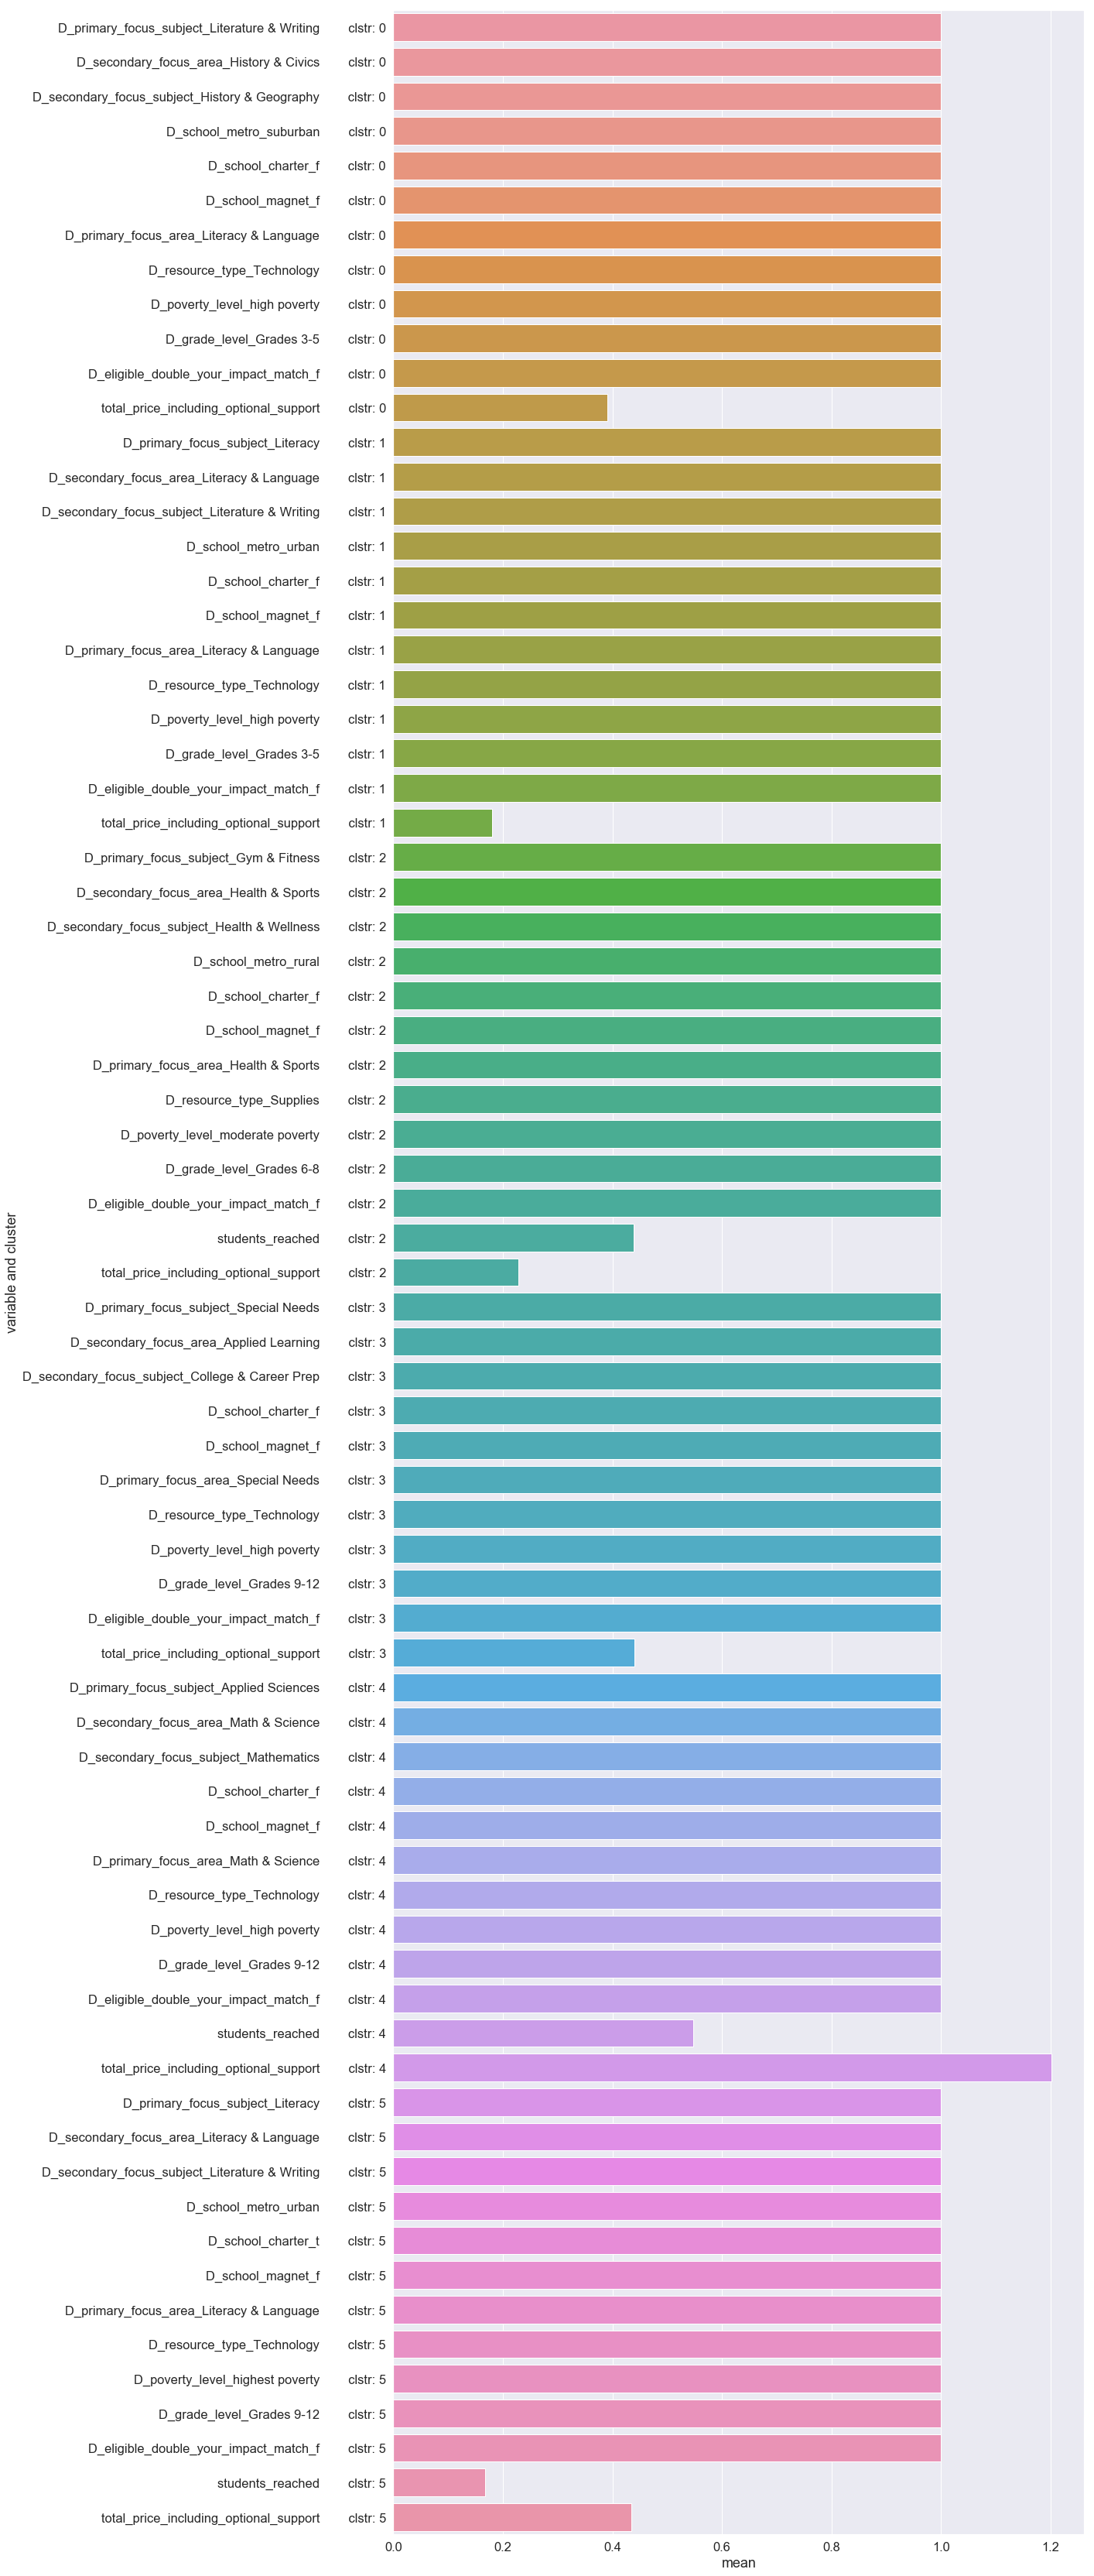

In [44]:
ulf.make_barplot_of_variable_means_by_cluster(data=subset_of_5pct, mymodel_labels=kmeans6.labels_)

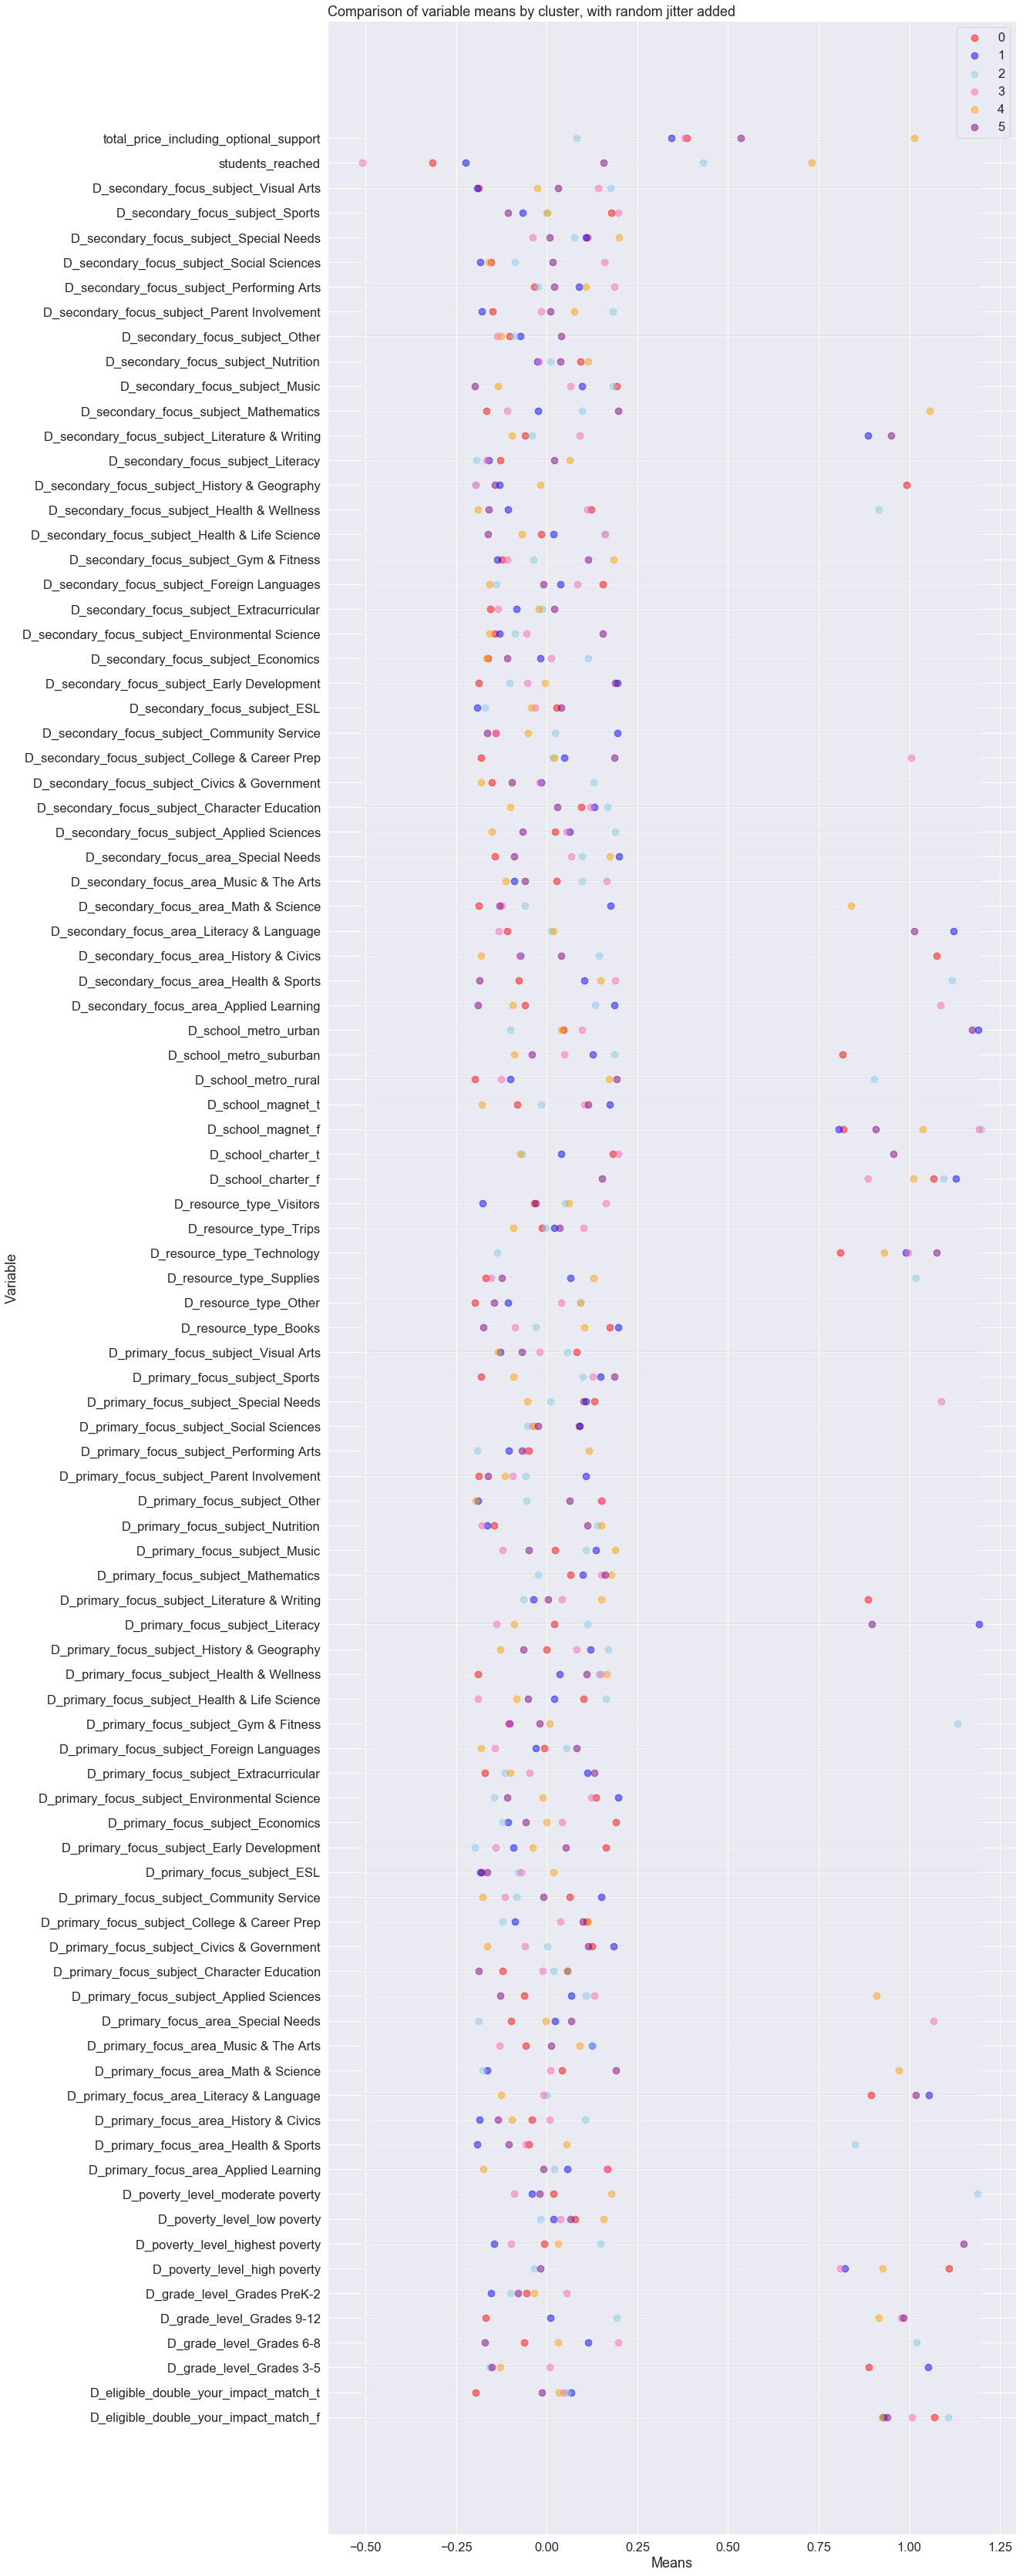

In [45]:
ulf.make_dotplot_of_variable_means_by_cluster(data=subset_of_5pct, mymodel_labels=kmeans6.labels_)

In [46]:
ulf.get_tree_feature_importances_by_cluster(data=subset_of_5pct, mymodel_labels=kmeans6.labels_)

This gives feature importances for our various clusters:

current cluster is  0
                                       var  importance
72     D_primary_focus_area_Math & Science    0.804818
92  total_price_including_optional_support    0.091328
91                        students_reached    0.066393
74      D_primary_focus_area_Special Needs    0.009202
85                D_grade_level_Grades 3-5    0.009186




current cluster is  1
                                        var  importance
92   total_price_including_optional_support    0.904528
91                         students_reached    0.052732
27  D_secondary_focus_area_Applied Learning    0.023313
63                     D_school_metro_urban    0.019428
59         D_secondary_focus_subject_Sports    0.000000




current cluster is  2
                                       var  importance
92  total_price_including_optional_support         1.0
59        D_secondary_focus_subject_Sports         0.0
68   D_primary_focus_area_Applied Lea